# 🧪 Toxic Comment Classification (Jigsaw) — End-to-End Notebook
# Single-model optimization with a quick 2-model benchmark phase



---

## 0. Setup & Config

In [91]:
import os, sys, math, json, random, gc, time, shutil, inspect
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import evaluate

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup,
)
import transformers as hf

print("Transformers:", hf.__version__)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED   = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ====== PATHS: set this to your local location ======
DATA_PATH = "./data/train.csv"  # <- change if needed
OUT_DIR   = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Labels in Jigsaw dataset
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

# Base configs
BASE_MODELS = {
    "distilbert-base-uncased": {"max_length": 192},
    "bert-base-uncased":      {"max_length": 192}
}

# Subset sizes (smaller on CPU to keep it practical)
if DEVICE == "cuda":
    QUICK_TRAIN_SIZE = 8000   # for quick benchmark per model
    QUICK_VAL_SIZE   = 2000
else:
    QUICK_TRAIN_SIZE = 2000
    QUICK_VAL_SIZE   = 800

# Final training sizes (Phase 2) — you can increase if GPU available
FINAL_TRAIN_FRACTION = 0.9   # 90% of train split used for training; rest for val
EPOCHS_BENCHMARK     = 1     # quick head-to-head
EPOCHS_FINAL         = 3     # main optimization run
BATCH_SIZE           = 16 if DEVICE == "cuda" else 8
LR_BENCHMARK         = 2e-5
LR_FINAL             = 2e-5
WEIGHT_DECAY         = 0.01
PATIENCE             = 2     # early stopping patience for final run

Transformers: 4.57.1
Torch: 2.5.1
CUDA available: True


---

## 1. Load & Inspect Data

In [92]:
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}\nMake sure train.csv is available."

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


toxic            0.095844
obscene          0.052948
insult           0.049364
severe_toxic     0.009996
identity_hate    0.008805
threat           0.002996
dtype: float64


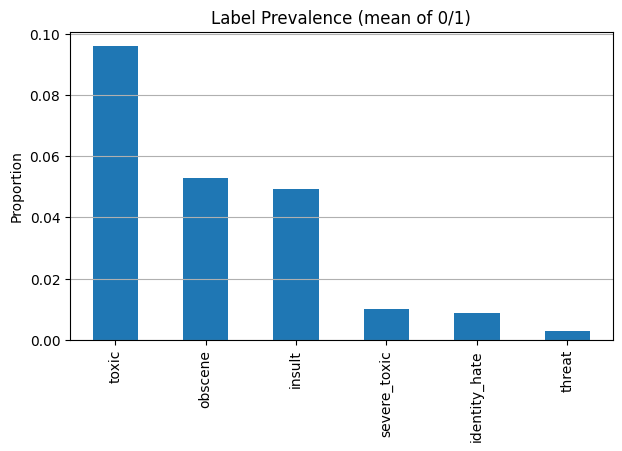

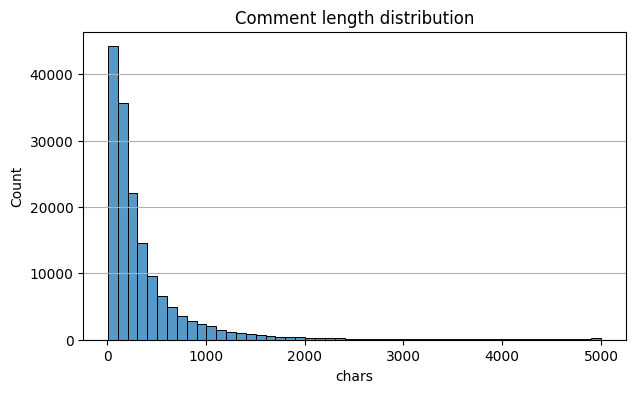

In [93]:
# Basic checks
for col in LABELS:
    assert col in df.columns, f"Missing label column '{col}' in train.csv"

df["total_labels"] = df[LABELS].sum(axis=1)
print(df[LABELS].mean().sort_values(ascending=False))  # class prevalence

plt.figure(figsize=(7,4))
df[LABELS].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Label Prevalence (mean of 0/1)"); plt.ylabel("Proportion"); plt.grid(axis='y'); plt.show()

plt.figure(figsize=(7,4))
df["comment_text_len"] = df["comment_text"].astype(str).str.len()
sns.histplot(df["comment_text_len"], bins=50, kde=False)
plt.title("Comment length distribution"); plt.xlabel("chars"); plt.grid(axis='y'); plt.show()

---

## 2. Train/Validation/Test Split

In [94]:
# Standard split: keep a holdout test set from training csv (since Kaggle provides separate test on platform)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED, stratify=(df[LABELS].sum(axis=1)>0))

# Smaller sampled sets for quick benchmark
def sample_balanced(df_in, n):
    n = min(n, len(df_in))
    # simple random for speed; optionally stratify by 'any_toxic'
    return df_in.sample(n=n, random_state=SEED)

train_quick = sample_balanced(train_df, QUICK_TRAIN_SIZE)
val_quick   = sample_balanced(test_df, QUICK_VAL_SIZE)

print("Quick train:", train_quick.shape, "Quick val:", val_quick.shape)

Quick train: (8000, 10) Quick val: (2000, 10)


---

## 3. Hugging Face Datasets & Tokenization

In [95]:
from datasets import Dataset
import numpy as np

def to_hf_dataset(df_in):
    # Keep your existing structure: text + multi-hot columns
    return Dataset.from_pandas(df_in[["comment_text"] + LABELS].reset_index(drop=True))

def tokenize_function(examples, tokenizer, max_length):
    return tokenizer(
        examples["comment_text"],
        padding=False,
        truncation=True,
        max_length=max_length
    )

def build_hf_splits(train_df, val_df, tokenizer, max_length):
    ds_train = to_hf_dataset(train_df)
    ds_val   = to_hf_dataset(val_df)

    def add_labels_and_tokens(batch):
        # 1) tokenize the text
        tok = tokenizer(
            batch["comment_text"],
            padding=False,
            truncation=True,
            max_length=max_length
        )
        # 2) build labels as float32 arrays from your multi-hot columns
        labs = []
        for i in range(len(batch["comment_text"])):
            labs.append([float(batch[lbl][i]) for lbl in LABELS])
        tok["labels"] = np.asarray(labs, dtype=np.float32)
        return tok

    # Remove raw columns after mapping to keep only model inputs
    keep_cols = {"comment_text", *LABELS}
    remove_cols_train = [c for c in ds_train.column_names if c in keep_cols]
    remove_cols_val   = [c for c in ds_val.column_names if c in keep_cols]

    ds_train = ds_train.map(add_labels_and_tokens, batched=True, remove_columns=remove_cols_train)
    ds_val   = ds_val.map(add_labels_and_tokens,   batched=True, remove_columns=remove_cols_val)

    # torch format for Trainer
    cols = ["input_ids", "attention_mask", "labels"]
    if "token_type_ids" in ds_train.column_names:
        cols.append("token_type_ids")
    ds_train = ds_train.with_format(type="torch", columns=cols)
    ds_val   = ds_val.with_format(type="torch",   columns=cols)

    return {"train": ds_train, "validation": ds_val}


---

## 4. Class Weights (to mitigate imbalance)

In [96]:
# Compute positive rate per label and derive inverse-frequency weights
pos_rates = train_quick[LABELS].mean().values
class_weights = 1.0 / np.clip(pos_rates, 1e-6, None)
class_weights = class_weights / class_weights.mean()  # normalize
CLASS_WEIGHTS_TENSOR = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

dict(zip(LABELS, class_weights))

{'toxic': np.float64(0.1289755707099587),
 'severe_toxic': np.float64(1.2703210320610998),
 'obscene': np.float64(0.23299858125743786),
 'threat': np.float64(2.727453980601773),
 'insult': np.float64(0.25616971088524937),
 'identity_hate': np.float64(1.3840811244844817)}

---

## 5. Metrics (Multi-Label: macro-F1, weighted-F1, macro ROC-AUC, per-label F1)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics_fn(eval_pred):
    logits, y_true = eval_pred
    probs = sigmoid(logits)

    # Tune a global threshold on the eval set (simple & effective)
    candidates = np.linspace(0.05, 0.5, 10)
    best_t, best_macro = 0.5, -1.0
    for t in candidates:
        y_hat = (probs >= t).astype(int)
        f1m = f1_score(y_true, y_hat, average="macro", zero_division=0)
        if f1m > best_macro:
            best_macro, best_t = f1m, t

    y_pred = (probs >= best_t).astype(int)

    f1_macro   = f1_score(y_true, y_pred, average="macro",   zero_division=0)
    f1_weight  = f1_score(y_true, y_pred, average="weighted",zero_division=0)
    try:
        roc_macro = roc_auc_score(y_true, probs, average="macro")
    except Exception:
        roc_macro = float("nan")

    f1_per = f1_score(y_true, y_pred, average=None, zero_division=0)
    out = {
        "f1_macro": float(f1_macro),
        "f1_weight": float(f1_weight),
        "roc_auc_macro": float(roc_macro),
        "best_thr": float(best_t),
    }
    for i, name in enumerate(LABELS):
        out[f"f1_{name}"] = float(f1_per[i])
    return out


---

## 6. Custom Loss: BCEWithLogits + Class Weights

In [98]:
from transformers import Trainer
import torch
import torch.nn as nn

class MultiLabelTrainer(Trainer):
    def __init__(self, *args, processing_class=None, tokenizer=None, class_weights=None, **kwargs):
        if processing_class is None and tokenizer is not None:
            processing_class = tokenizer

        self._class_weights = class_weights
        super().__init__(*args, processing_class=processing_class, **kwargs)
        self.processing_class = processing_class
        self._bce = None

    # optional back-compat shim to avoid deprecation noise
    @property
    def tokenizer(self):
        return getattr(self, "processing_class", None)

    @tokenizer.setter
    def tokenizer(self, value):
        self.processing_class = value

    def _ensure_loss(self):
        if self._bce is not None:
            return self._bce
        pos_weight = None
        if self._class_weights is not None:
            pos_weight = self._class_weights
            if not torch.is_floating_point(pos_weight):
                pos_weight = pos_weight.float()
            pos_weight = pos_weight.to(self.model.device)
        self._bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        return self._bce

    # <-- Accept extra kwargs to stay compatible with Trainer
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # accept both "labels" and "label"
        labels = None
        if "labels" in inputs:
            labels = inputs.pop("labels")
        elif "label" in inputs:
            labels = inputs.pop("label")

        outputs = model(**inputs)
        logits = outputs.logits

        if labels is None:
            # If the model produced a loss itself, use it (rare for multi-label)
            maybe = getattr(outputs, "loss", None)
            if maybe is not None:
                loss = maybe
            else:
                raise ValueError(
                    "No labels found in batch. Expected a tensor under 'labels' (or 'label'). "
                    "Ensure your dataset map returns that key and dtype float32 for multi-label."
                )
        else:
            if labels.dtype != torch.float32:
                labels = labels.float()
            labels = labels.to(logits.device)
            loss = self._ensure_loss()(logits, labels)

        return (loss, outputs) if return_outputs else loss

---

## 7. Phase 1 – Quick Head-to-Head (DistilBERT vs BERT-base)

In [99]:
import os, json, dataclasses, inspect
import torch
import transformers as hf
from packaging import version
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments
)

# ---------- Helpers ----------
def supports_tf32() -> bool:
    # Require CUDA runtime + Ampere (SM 8.0+) to safely enable TF32
    if not torch.cuda.is_available() or torch.version.cuda is None:
        return False
    major, minor = torch.cuda.get_device_capability()
    return major >= 8  # Ampere or newer

def make_training_args(**kwargs):
    # Keep only the kwargs your installed TrainingArguments supports
    valid = {f.name for f in dataclasses.fields(TrainingArguments)}
    filtered = {k: v for k, v in kwargs.items() if k in valid and v is not None}
    return TrainingArguments(**filtered)

# ---------- Device & dtypes ----------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_bf16 = (DEVICE == "cuda") and torch.cuda.is_bf16_supported()
use_fp16 = (DEVICE == "cuda") and (not use_bf16)
use_tf32 = supports_tf32()  # <-- SAFE

if DEVICE == "cuda":
    # Only set these hints when CUDA is available
    try:
        torch.backends.cuda.matmul.allow_tf32 = use_tf32
    except Exception:
        pass
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

print("Transformers:", hf.__version__)
print("TrainingArguments from:", inspect.getsourcefile(TrainingArguments))
print("Device:", DEVICE, "| bf16:", use_bf16, "| fp16:", use_fp16, "| tf32:", use_tf32)

# Version-proof eval strategy key (v4 vs v5)
eval_kw = (
    {"evaluation_strategy": "epoch"}  # transformers 4.x
    if version.parse(hf.__version__) < version.parse("5.0.0")
    else {"eval_strategy": "epoch"}   # transformers 5.x
)

results_benchmark = {}

# (Optional) ensure class weights live on the same device the model will use
if DEVICE == "cuda" and CLASS_WEIGHTS_TENSOR.device.type != "cuda":
    CLASS_WEIGHTS_TENSOR = CLASS_WEIGHTS_TENSOR.to("cuda")

for model_name, cfg in BASE_MODELS.items():
    print(f"\n===== Benchmarking: {model_name} =====")
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    ds_quick = build_hf_splits(train_quick, val_quick, tokenizer, cfg["max_length"])
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    num_labels = len(LABELS)
    torch_dtype = torch.bfloat16 if use_bf16 else (torch.float16 if use_fp16 else torch.float32)

    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="multi_label_classification"
    )
    model  = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
        torch_dtype=torch_dtype
    )

    # Build args with only supported fields; tf32 is passed as False on unsupported hw
    import platform

    num_workers = 0 if platform.system() == "Windows" else max(1, (os.cpu_count() or 4)//2)

    args = make_training_args(
        output_dir=os.path.join(OUT_DIR, f"{model_name.replace('/','_')}_bench"),
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LR_BENCHMARK,
        num_train_epochs=EPOCHS_BENCHMARK,

        # make v4/v5 happy
        **eval_kw,
        save_strategy="no",
        logging_steps=50,
        report_to="none",
        load_best_model_at_end=False,
        disable_tqdm=False,

        # <<< fix the crash >>>
        gradient_accumulation_steps=1,   # ensure it's an int, not None

        # GPU-friendly flags:
        bf16=use_bf16,
        fp16=use_fp16,
        tf32=use_tf32,
        dataloader_pin_memory=(DEVICE == "cuda"),
        dataloader_num_workers=num_workers,
        dataloader_persistent_workers=False,

        optim="adamw_torch",
        gradient_checkpointing=True,
        label_names=["labels"],
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        # torch_compile=True,
    )

    trainer = MultiLabelTrainer(
        model=model,
        args=args,
        train_dataset=ds_quick["train"],
        eval_dataset=ds_quick["validation"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_fn,
        class_weights=CLASS_WEIGHTS_TENSOR,
    )

    train_out = trainer.train()
    eval_out  = trainer.evaluate()
    results_benchmark[model_name] = eval_out
    print(f"Eval: {eval_out}")

print("\nBenchmark summary:")
print(json.dumps(results_benchmark, indent=2))


Transformers: 4.57.1
TrainingArguments from: c:\Users\natha\miniconda3\envs\DL_ToxicCommentClassif\lib\site-packages\transformers\training_args.py
Device: cuda | bf16: True | fp16: False | tf32: False

===== Benchmarking: distilbert-base-uncased =====


Map: 100%|██████████| 2000/2000 [00:00<00:00, 12952.56 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.555800
100,0.333100
150,0.207500
200,0.169500
250,0.147800
300,0.137100
350,0.135600
400,0.122200
450,0.124300
500,0.129700


Eval: {'eval_loss': 0.11643587052822113, 'eval_f1_macro': 0.14006117345432698, 'eval_f1_weight': 0.1866774023938092, 'eval_roc_auc_macro': 0.7382017309818281, 'eval_best_thr': 0.1, 'eval_f1_toxic': 0.19086386250565354, 'eval_f1_severe_toxic': 0.1935483870967742, 'eval_f1_obscene': 0.19724770642201836, 'eval_f1_threat': 0.019417475728155338, 'eval_f1_insult': 0.1984732824427481, 'eval_f1_identity_hate': 0.04081632653061224, 'eval_runtime': 8.016, 'eval_samples_per_second': 249.501, 'eval_steps_per_second': 15.594, 'epoch': 1.0}

===== Benchmarking: bert-base-uncased =====


Map: 100%|██████████| 2000/2000 [00:00<00:00, 11597.93 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.512400
100,0.260100
150,0.159100
200,0.132500
250,0.117000
300,0.110400
350,0.110300
400,0.096800
450,0.100000
500,0.107200


Eval: {'eval_loss': 0.0930660143494606, 'eval_f1_macro': 0.0660505918258851, 'eval_f1_weight': 0.13172871495456806, 'eval_roc_auc_macro': 0.6989373571579294, 'eval_best_thr': 0.05, 'eval_f1_toxic': 0.19086386250565354, 'eval_f1_severe_toxic': 0.015174506828528073, 'eval_f1_obscene': 0.08703969392635102, 'eval_f1_threat': 0.0029955067398901645, 'eval_f1_insult': 0.08337326305701964, 'eval_f1_identity_hate': 0.01685671789786812, 'eval_runtime': 15.8301, 'eval_samples_per_second': 126.342, 'eval_steps_per_second': 7.896, 'epoch': 1.0}

Benchmark summary:
{
  "distilbert-base-uncased": {
    "eval_loss": 0.11643587052822113,
    "eval_f1_macro": 0.14006117345432698,
    "eval_f1_weight": 0.1866774023938092,
    "eval_roc_auc_macro": 0.7382017309818281,
    "eval_best_thr": 0.1,
    "eval_f1_toxic": 0.19086386250565354,
    "eval_f1_severe_toxic": 0.1935483870967742,
    "eval_f1_obscene": 0.19724770642201836,
    "eval_f1_threat": 0.019417475728155338,
    "eval_f1_insult": 0.1984732824427

> **Choose the final model**: pick the one with higher `f1_macro` (and `roc_auc_macro`). Typically DistilBERT is faster; BERT-base may be slightly better if you have GPU.

In [100]:
# Auto-select best by f1_macro
best_model_name = max(results_benchmark.keys(), key=lambda k: results_benchmark[k]["eval_f1_macro"])
best_model_name

'distilbert-base-uncased'

---

## 8. Phase 2 – Final Training & Optimization (single chosen model)

In [103]:
import os, platform
import numpy as np
import torch
import transformers as hf
from packaging import version
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, EarlyStoppingCallback
)

# ---------- device & dtype ----------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_bf16 = (DEVICE == "cuda") and torch.cuda.is_bf16_supported()
use_fp16 = (DEVICE == "cuda") and (not use_bf16)

def supports_tf32() -> bool:
    if not torch.cuda.is_available() or torch.version.cuda is None:
        return False
    major, _ = torch.cuda.get_device_capability()
    return major >= 8  # Ampere+

use_tf32 = supports_tf32()
if DEVICE == "cuda":
    try: torch.backends.cuda.matmul.allow_tf32 = use_tf32
    except Exception: pass
    try: torch.set_float32_matmul_precision("high")
    except Exception: pass

# ---------- pick model ----------
FINAL_MODEL = best_model_name  # or set manually e.g. "distilbert-base-uncased"
print("Final chosen model:", FINAL_MODEL)

# ---------- split ----------
train_full, val_full = train_test_split(
    train_df,
    test_size=(1 - FINAL_TRAIN_FRACTION),
    random_state=SEED,
    stratify=(train_df[LABELS].sum(axis=1) > 0)
)

# ---------- tokenizer / datasets ----------
tokenizer = AutoTokenizer.from_pretrained(FINAL_MODEL, use_fast=True)
max_len   = BASE_MODELS[FINAL_MODEL]["max_length"]
ds_full   = build_hf_splits(train_full, val_full, tokenizer, max_len)

# data collator (ok to keep)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ---------- model ----------
num_labels = len(LABELS)
torch_dtype = torch.bfloat16 if use_bf16 else (torch.float16 if use_fp16 else torch.float32)

config = AutoConfig.from_pretrained(
    FINAL_MODEL,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)
model  = AutoModelForSequenceClassification.from_pretrained(
    FINAL_MODEL,
    config=config,
    torch_dtype=torch_dtype
)

print("Train samples:", len(ds_full["train"]), "Val samples:", len(ds_full["validation"]))

# ---------- TrainingArguments (v4/v5 compatible) ----------
num_workers = 0 if platform.system() == "Windows" else max(1, (os.cpu_count() or 4)//2)
eval_kw = (
    {"evaluation_strategy": "epoch"} if version.parse(hf.__version__) < version.parse("5.0.0")
    else {"eval_strategy": "epoch"}
)

args_final = make_training_args(
    output_dir=os.path.join(OUT_DIR, f"{FINAL_MODEL.replace('/','_')}_final"),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR_FINAL,
    num_train_epochs=EPOCHS_FINAL,
    weight_decay=WEIGHT_DECAY,
    save_strategy="epoch",
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="none",
    disable_tqdm=False,

    # labels & stability
    label_names=["labels"],
    gradient_accumulation_steps=1,

    # GPU / dataloader flags
    bf16=use_bf16,
    fp16=use_fp16,
    tf32=use_tf32,
    dataloader_pin_memory=(DEVICE == "cuda"),
    dataloader_num_workers=num_workers,
    dataloader_persistent_workers=False,

    # mild regularization
    warmup_ratio=0.1,
    optim="adamw_torch",

    # evaluation strategy (v4 vs v5) — pass BOTH, the helper will keep the valid one
    evaluation_strategy="epoch",   # for transformers < 5
    eval_strategy="epoch",         # for transformers >= 5
)

early_stop = EarlyStoppingCallback(
    early_stopping_patience=PATIENCE,
    early_stopping_threshold=0.0
)

trainer_final = MultiLabelTrainer(
    model=model,
    args=args_final,
    train_dataset=ds_full["train"],
    eval_dataset=ds_full["validation"],
    processing_class=tokenizer,      # <-- future-proof (replaces tokenizer=tokenizer)
    data_collator=data_collator,
    compute_metrics=compute_metrics_fn,
    callbacks=[early_stop],
    class_weights=CLASS_WEIGHTS_TENSOR
)

train_res = trainer_final.train()
best_metrics = trainer_final.evaluate()
best_metrics


Final chosen model: distilbert-base-uncased


Map: 100%|██████████| 14362/14362 [00:01<00:00, 12119.83 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train samples: 129251 Val samples: 14362


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weight,Roc Auc Macro,Best Thr,F1 Toxic,F1 Severe Toxic,F1 Obscene,F1 Threat,F1 Insult,F1 Identity Hate
1,0.064400,0.054640,0.456249,0.635617,0.961958,0.100000,0.645346,0.358974,0.740847,0.093023,0.662172,0.237129
2,0.062400,0.054487,0.458463,0.646431,0.964240,0.100000,0.659155,0.345578,0.748603,0.089347,0.678832,0.229261
3,0.051800,0.054486,0.458263,0.646987,0.964314,0.100000,0.661668,0.344640,0.746518,0.089347,0.678832,0.228571


{'eval_loss': 0.054486941546201706,
 'eval_f1_macro': 0.45846277396578317,
 'eval_f1_weight': 0.6464305719930997,
 'eval_roc_auc_macro': 0.9642398655311939,
 'eval_best_thr': 0.1,
 'eval_f1_toxic': 0.6591549295774648,
 'eval_f1_severe_toxic': 0.345578231292517,
 'eval_f1_obscene': 0.7486033519553073,
 'eval_f1_threat': 0.08934707903780069,
 'eval_f1_insult': 0.6788321167883211,
 'eval_f1_identity_hate': 0.22926093514328807,
 'eval_runtime': 57.6606,
 'eval_samples_per_second': 249.078,
 'eval_steps_per_second': 15.574,
 'epoch': 3.0}


---

## 9. Detailed Evaluation: Per-Label Reports, Curves

In [104]:
# Predictions on validation set
raw = trainer_final.predict(ds_full["validation"])
logits = raw.predictions
probs  = 1 / (1 + np.exp(-logits))
y_true = np.stack([ds_full["validation"][l] for l in LABELS], axis=1)
y_pred = (probs >= 0.5).astype(int)

print("Macro F1:", classification_report(y_true, y_pred, target_names=LABELS, zero_division=0))

# ROC-AUC per label
try:
    roc_per_label = {LABELS[i]: roc_auc_score(y_true[:,i], probs[:,i]) for i in range(len(LABELS))}
    pd.Series(roc_per_label).sort_values(ascending=False)
except Exception as e:
    print("ROC-AUC per label error:", e)

# Plot probability histograms per label
fig, axes = plt.subplots(2,3, figsize=(14,8))
axes = axes.ravel()
for i, lab in enumerate(LABELS):
    sns.histplot(probs[:,i], bins=30, ax=axes[i], color="#3A8BFF")
    axes[i].set_title(f"Predicted P({lab})")
    axes[i].grid(axis='y')
plt.tight_layout(); plt.show()

ValueError: Column 'toxic' doesn't exist.

---

## 10. Save Artifacts & Inference Function

In [ ]:
SAVE_DIR = os.path.join(OUT_DIR, f"{FINAL_MODEL.replace('/','_')}_BEST")
trainer_final.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

def predict_texts(texts, path=SAVE_DIR, threshold=0.5):
    tok = AutoTokenizer.from_pretrained(path)
    cfg = AutoConfig.from_pretrained(path)
    mdl = AutoModelForSequenceClassification.from_pretrained(path).to(DEVICE)
    mdl.eval()
    enc = tok(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        logits = mdl(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= threshold).astype(int)
    return probs, preds

probs, preds = predict_texts(["I will find you and I will hurt you.","Have a wonderful day!"])
pd.DataFrame(probs, columns=LABELS)

---

## 10B. Evaluate on Kaggle Test Set & Create Submission (Optional)

Use the official Kaggle `test.csv` and `test_labels.csv` to:
1) Evaluate the model locally on the subset where labels are released (labels ≠ -1), and  
2) Produce a `submission.csv` for Kaggle (probabilities only).

> Place `test.csv`, `test_labels.csv`, and `sample_submission.csv` in the project folder (same as `train.csv`).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# Paths (adjust if needed)
TEST_PATH          = "./test.csv"
TEST_LABELS_PATH   = "./test_labels.csv"
SAMPLE_SUB_PATH    = "./sample_submission.csv"
SUBMISSION_OUTPATH = "./submission.csv"

# 1) Load Kaggle test and labels
test_df        = pd.read_csv(TEST_PATH)
test_labels_df = pd.read_csv(TEST_LABELS_PATH)

print("Test shape:", test_df.shape)
print("Test labels shape:", test_labels_df.shape)
display(test_df.head())
display(test_labels_df.head())

# 2) Generate probabilities for ALL test comments
test_texts = test_df["comment_text"].astype(str).tolist()
probs_all, preds_all = predict_texts(test_texts, path=SAVE_DIR, threshold=0.5)  # uses the saved best model
print("Predictions shape:", probs_all.shape)

# 3) Evaluate only where Kaggle released ground-truth labels (rows with labels != -1)
mask_valid = (test_labels_df["toxic"] != -1)
valid_idx = test_labels_df.index[mask_valid].tolist()

y_true = test_labels_df.loc[valid_idx, LABELS].values.astype(int)
y_prob = probs_all[valid_idx]
y_pred = (y_prob >= 0.5).astype(int)

# Metrics on released subset
f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)
f1_weight  = f1_score(y_true, y_pred, average="weighted", zero_division=0)
try:
    roc_macro = roc_auc_score(y_true, y_prob, average="macro")
except Exception:
    roc_macro = float("nan")

print(f"Released-subset metrics | F1_macro: {f1_macro:.4f} | F1_weighted: {f1_weight:.4f} | ROC_AUC_macro: {roc_macro:.4f}")
print("\nPer-label F1:")
print(pd.Series(
    f1_score(y_true, y_pred, average=None, zero_division=0),
    index=LABELS
).sort_values(ascending=False))

# Optional: detailed report
print("\nClassification report (threshold = 0.5):")
print(classification_report(y_true, y_pred, target_names=LABELS, zero_division=0))

### (Optional) Threshold Tuning on Validation Set
Optimize a single global threshold using your **validation** predictions to maximize macro-F1, then reuse it on the Kaggle test subset.


In [ ]:
# Reuse validation predictions from section 9:
#   raw = trainer_final.predict(ds_full["validation"])
# If you no longer have `raw`, re-run that cell first.
val_logits = raw.predictions
val_probs  = 1 / (1 + np.exp(-val_logits))
val_true   = np.stack([ds_full["validation"][l] for l in LABELS], axis=1)

best_thr, best_f1 = 0.5, -1
for thr in np.linspace(0.2, 0.8, 13):
    f1m = f1_score(val_true, (val_probs >= thr).astype(int), average="macro", zero_division=0)
    if f1m > best_f1:
        best_f1, best_thr = f1m, float(thr)

print(f"Best global threshold on validation: {best_thr:.2f} (macro-F1={best_f1:.4f})")

# Apply tuned threshold on Kaggle test subset and re-evaluate
y_pred_tuned = (y_prob >= best_thr).astype(int)
f1_macro_tuned  = f1_score(y_true, y_pred_tuned, average="macro", zero_division=0)
f1_weight_tuned = f1_score(y_true, y_pred_tuned, average="weighted", zero_division=0)

print(f"Released-subset metrics (tuned thr {best_thr:.2f}) | F1_macro: {f1_macro_tuned:.4f} | F1_weighted: {f1_weight_tuned:.4f}")

### Create `submission.csv` (for Kaggle)
Fill the sample submission with your **probabilities** (not hard labels) and save.


In [ ]:
sub = pd.read_csv(SAMPLE_SUB_PATH)
assert all(col in sub.columns for col in LABELS), "Sample submission missing expected label columns."

# IMPORTANT: order must match test_df rows
# sub['id'] aligns with test_df['id'] by Kaggle convention
sub[LABELS] = probs_all  # use probabilities (floats in [0,1])
sub.to_csv(SUBMISSION_OUTPATH, index=False)
print("Saved Kaggle submission to:", os.path.abspath(SUBMISSION_OUTPATH))

# Tip: upload this CSV on the Kaggle competition page to get a leaderboard score.

---

## 11. Gradio Demo (Local App)

In [ ]:
import gradio as gr

def classify_comment(text, threshold=0.5):
    pr, pd_bin = predict_texts([text], path=SAVE_DIR, threshold=float(threshold))
    pr = pr[0]; pd_bin = pd_bin[0]
    result = {LABELS[i]: float(pr[i]) for i in range(len(LABELS))}
    preds  = {LABELS[i]: int(pd_bin[i]) for i in range(len(LABELS))}
    return result, preds

demo = gr.Interface(
    fn=classify_comment,
    inputs=[gr.Textbox(lines=4, label="Comment"), gr.Slider(0.1, 0.9, value=0.5, step=0.05, label="Decision threshold")],
    outputs=[gr.Label(num_top_classes=6, label="Probabilities"), gr.JSON(label="Binary predictions (≥ threshold)")],
    title="Jigsaw Toxic Comment Classifier",
    description="DistilBERT/BERT multi-label classifier with sigmoid outputs."
)

# Uncomment to launch locally
# demo.launch(share=False)

---

## 12. Report Pointers (for exam write-up)

- **Problem framing**: Online moderation, multi-label toxicity detection.  
- **Data**: Jigsaw (2018), size, class imbalance, preprocessing decisions.  
- **Method**: Phase 1 benchmark (DistilBERT vs BERT-base) → Phase 2 optimization (chosen model).  
- **Loss**: `BCEWithLogitsLoss` with per-label `pos_weight`.  
- **Optimization**: LR 2e-5, batch 16 (GPU), early stopping, weight decay.  
- **Metrics**: Macro-F1 primary, Weighted-F1 secondary, Macro ROC-AUC; per-label F1 table.  
- **Results**: Show curves, tables, sample predictions.  
- **Ethics**: Bias, fairness, explainability (optional: SHAP on token importance), threshold choice & moderation policy.  
- **Reproducibility**: random seeds, environment, versions, saved artifacts. 

---

## 13. (Optional) Tips if CPU-only

- Use **DistilBERT** only; set `QUICK_TRAIN_SIZE=1000`, `QUICK_VAL_SIZE=400`, `EPOCHS_FINAL=2`.  
- Reduce `max_length` to **128**.  
- Consider **gradient accumulation** to emulate larger batch sizes:
  - Add `gradient_accumulation_steps=2` in `TrainingArguments`.
- Expect much slower training; use the notebook to validate pipeline, then scale on Colab GPU.